# Collect Runtime Statistics with `Watcher`

The `Watcher` module can collect runtime statistics. It uses
the observer pattern: once an `Watcher` is registered to an
`Algorithm`, events reported by the `Algorithm` may handlers 

This module is useful when the algorithm has a complicated `.step(..)`.
Otherwise, it is always possible to collect information by inspecting
the `Algorithm` in between iterations.

Running this tutorial requires `matplotlib`.

### Construct Algorithm

To begin, consider a simple GA with the following configuration:

| Component  | Choice                                          |
| ----------- | ---------------------------------------------- |
|Individual|Binary string|
|Evaluator|OneMax|
|Selector|Elitist truncation|
|Variator|Mutation|

Use a population of 5000 individuals, each a 5000-bits long binary string.
EvoKit has all building blocks for this algorithm; for convenience,
automate its creation with a function:

In [109]:
from evokit.evolvables.prefabs import make_onemax

Because `CanonicalGeneticAlgorithm` has only one population,
this attribute can be accessed as `.population`. Operators of
this algorithm are not stateless and do not have much to offer
in terms of analytics.

In [110]:
import matplotlib.pyplot as plt

## The Manual Approach

For a simple example, collect then plot the fitness curve by generation:

In [114]:
STEP_COUNT: int = 30

algo = make_onemax(1000, 1000, 0.01)
best_fitnesses: list[float] = []

for _ in range(STEP_COUNT):
    algo.step()
    best_fitnesses.append(algo.population.best().fitness[0])

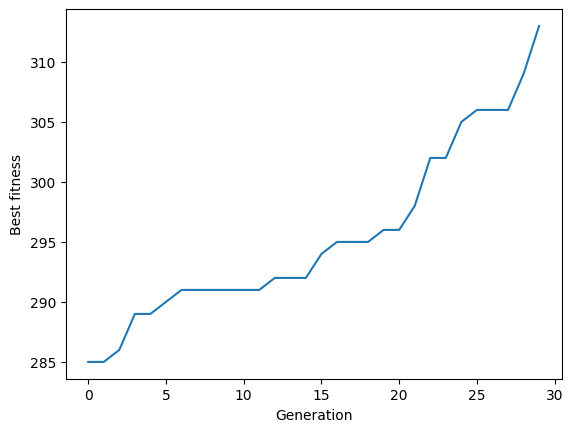

In [ ]:
plt.plot(range(STEP_COUNT), best_fitnesses)
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.show()

## Automating with Watcher

In `watch`, the `.Watcher` module automates statistics collection.
`watch.watchers` provides several simple watchers for reference.
In addition, `watch.visualisers` offers a suite of utilities
to plot collected data.

Instead of using a stock watcher, let's build our own!

### Inspecting Available Events

To create an watcher for an algorithm, it's best to check what
event the algorithm could report. An algorithm declares its standard
events in `.events`.

An `Algorithm` can fire events in two ways: (a) by calling `.update` (typically from inside `.step`), or automatically by the algorithm itself. As an example of the latter, all algorithms that derive the base class `Algorithm` fire `STEP_END` after `.step` is called.

To decide which events to watch, first check what events the algorithm is able to report:

In [ ]:
algo_2 = make_onemax(1000, 1000, 0.01)
print(f"events: {algo_2.events}; automatic events: {algo_2.automatic_events}")

events: ['POST_VARIATION', 'POST_EVALUATION', 'POST_SELECTION']; automatic events: ('POST_STEP',)


### Crafting an Watcher
An watcher must be created with `accounting.Watcher`.
The constructor takes three parameters: (a) a list of `events`
that can trigger collection, (b) a callable `handler` that collects
data from the associated algorithm, and (c) an optional parameter
that controls if the watcher should also `watch_automatic_events`.

For simplicity, declare an `Watcher` that collects the best fitness
from a population only on automatic events. Observe the signature:
the watcher collects...

* ... from a `HomogeneousAlgorithm` (`Algorithm` with one `.population`)
of `BitString`s,
* a `tuple` of one `float` that contains a fitness value.

An algorithm can register several watchers, which are
updated in order or registration. To check if the watcher
is registered, check if it is in `Algorithm.watchers`.

In [ ]:
from evokit.watch import Watcher
from evokit.evolvables.algorithms import HomogeneousAlgorithm
from evokit.evolvables.binstring import BitString

In [ ]:
fit_acc = Watcher[HomogeneousAlgorithm[BitString], tuple[float, ...]](
    events=[],
    handler=lambda algo: algo.population.best().fitness,
    watch_post_step=True)

algo_2.register(fit_acc)
assert(fit_acc in algo_2.watchers)

To see how things work under the hood, fire an
event in the algorithm, then check what the watcher
has collected.

Each record contains four values: (a) the event that triggered
collection, (b) the generation in which the event is fired, the
time (via `time.perf_timer`, in seconds) at which the event in fired,
and (d) the collected value.

Not all statistics are available at all times: for example, because
the population starts off unevaluated, the best fitness is
`(nan,)`.

In [ ]:
algo_2.update(algo.automatic_events[0])
print(fit_acc.report())

[WatcherRecord(event='POST_STEP', generation=0, value=(nan,), time=4.203125)]


Now, wipe all records from `fit_acc` and see how
it collects statistics from a running algorithm. Then, visualise
the results with a function from `accounting.visualisers`:

In [ ]:
fit_acc.purge()

for _ in range(STEP_COUNT):
    algo_2.step()

In [ ]:
fit_acc.report()[:4]

[WatcherRecord(event='POST_STEP', generation=0, value=(293,), time=4.203125),
 WatcherRecord(event='POST_STEP', generation=1, value=(293,), time=4.203125),
 WatcherRecord(event='POST_STEP', generation=2, value=(294,), time=4.203125),
 WatcherRecord(event='POST_STEP', generation=3, value=(294,), time=4.203125)]

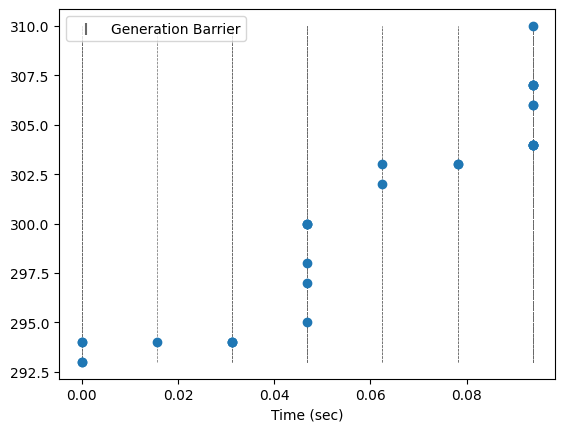

In [ ]:
from evokit.watch.visualisers import plot

plot(fit_acc.report(),
     track_generation=True,)

Notice that the visualiser highlights automatic events,
which mark boundaries of generations. It also plots data points
over runtime, which provides an intuitive view of training progression.

Compare against plotting fitness by generation, which does not show how much time each generation takes.

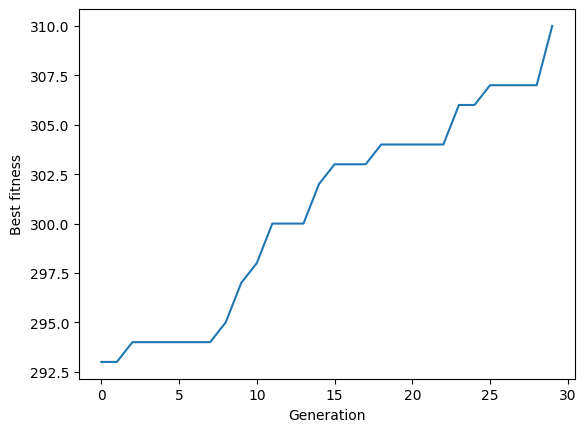

In [ ]:
_data = [x.value[0] for x in fit_acc.report()]
plt.plot(range(len(_data)), _data)
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.show()